In [28]:
import numpy as np

from functional import (
    plot_gray_images,
    plot_location,
    get_label_mask,
    Label,
    get_primitive_rectangles,
    draw_primitive_rectangles,
    load_masks,
    get_primitive_mask_by_rectangles,
    get_neighbor_pixels_of_label,
    PossibleLocations
)

%reload_ext autoreload
%autoreload 2

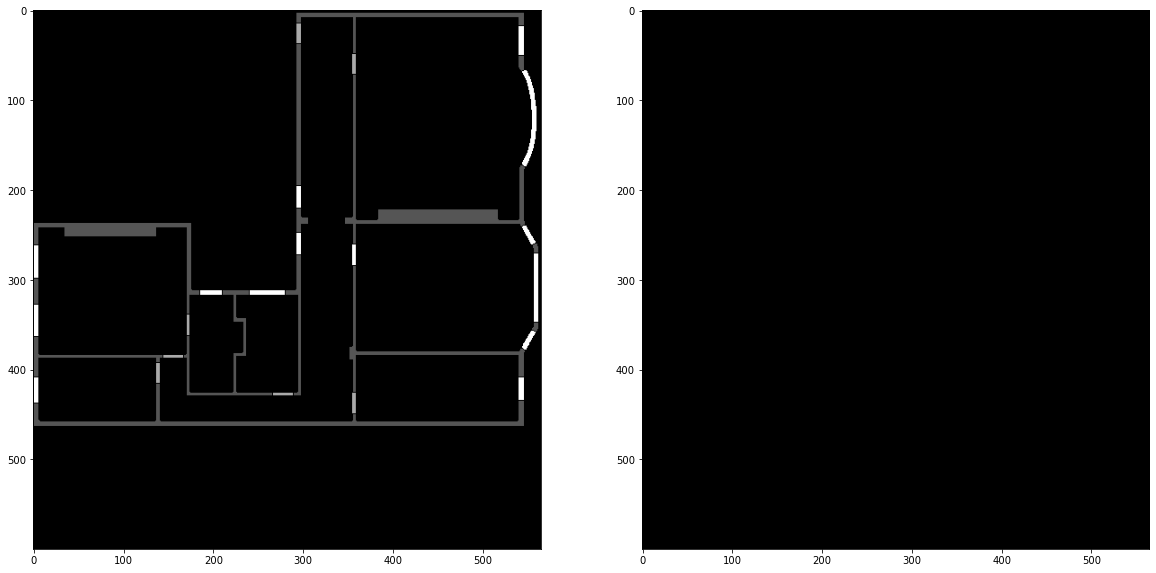

In [2]:
masks = load_masks('masks')
some_mask = masks[1]
plot_gray_images(some_mask)
# plot_gray_images(*masks)

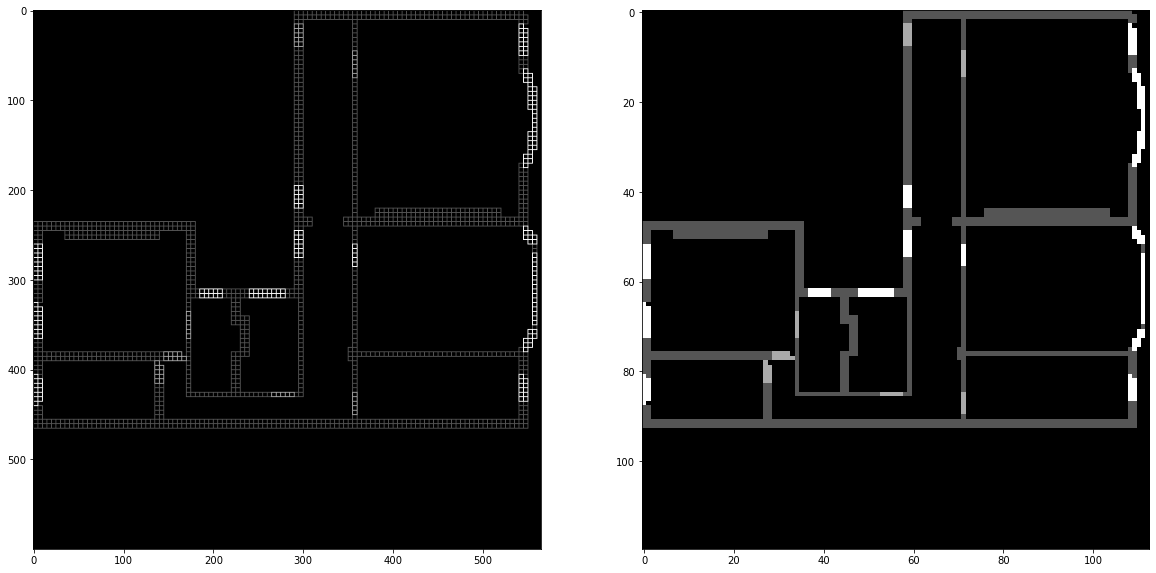

In [3]:
rectangles_mask = np.zeros_like(some_mask)
rectangles = dict()
for label in Label:
    label_mask = get_label_mask(some_mask, label)
    label_rectangles = get_primitive_rectangles(label_mask)
    rectangles[label] = label_rectangles
    draw_primitive_rectangles(rectangles_mask, label_rectangles, color=label.value)

primitive_mask = get_primitive_mask_by_rectangles(some_mask, rectangles)
plot_gray_images(rectangles_mask, primitive_mask)

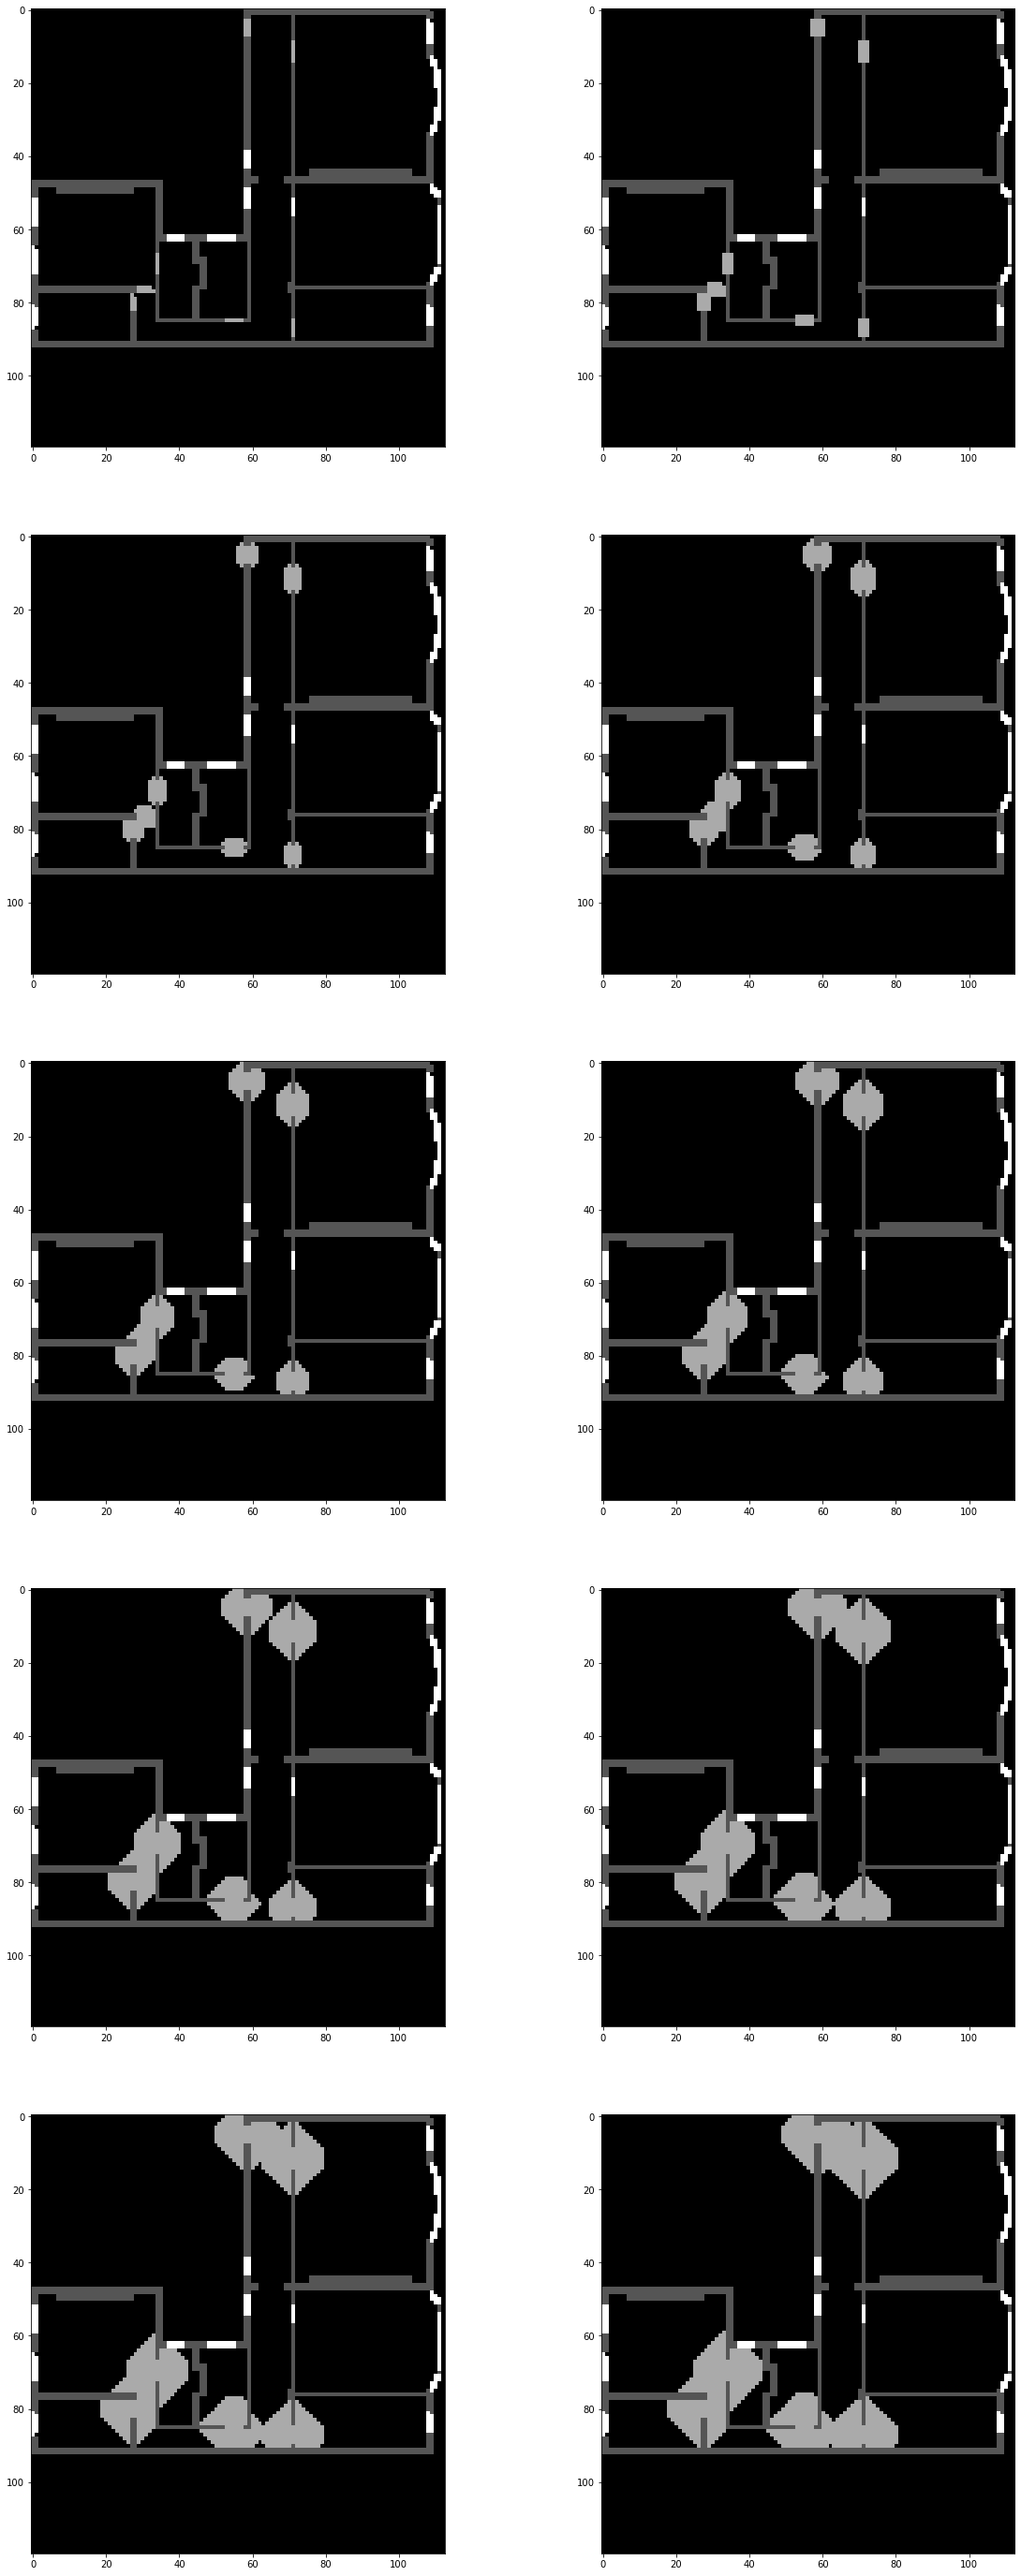

In [21]:
iter_num = 10

primitive_masks = np.ndarray(shape=(iter_num, *primitive_mask.shape), dtype=np.uint8)
primitive_masks[0] = primitive_mask.copy()

for idx in range(1, iter_num):
    previous_primitive_mask = primitive_masks[idx - 1].copy()
    neighbors = get_neighbor_pixels_of_label(previous_primitive_mask, Label.door)
    previous_primitive_mask[neighbors] = Label.door.value
    primitive_masks[idx] = previous_primitive_mask

plot_gray_images(*primitive_masks)

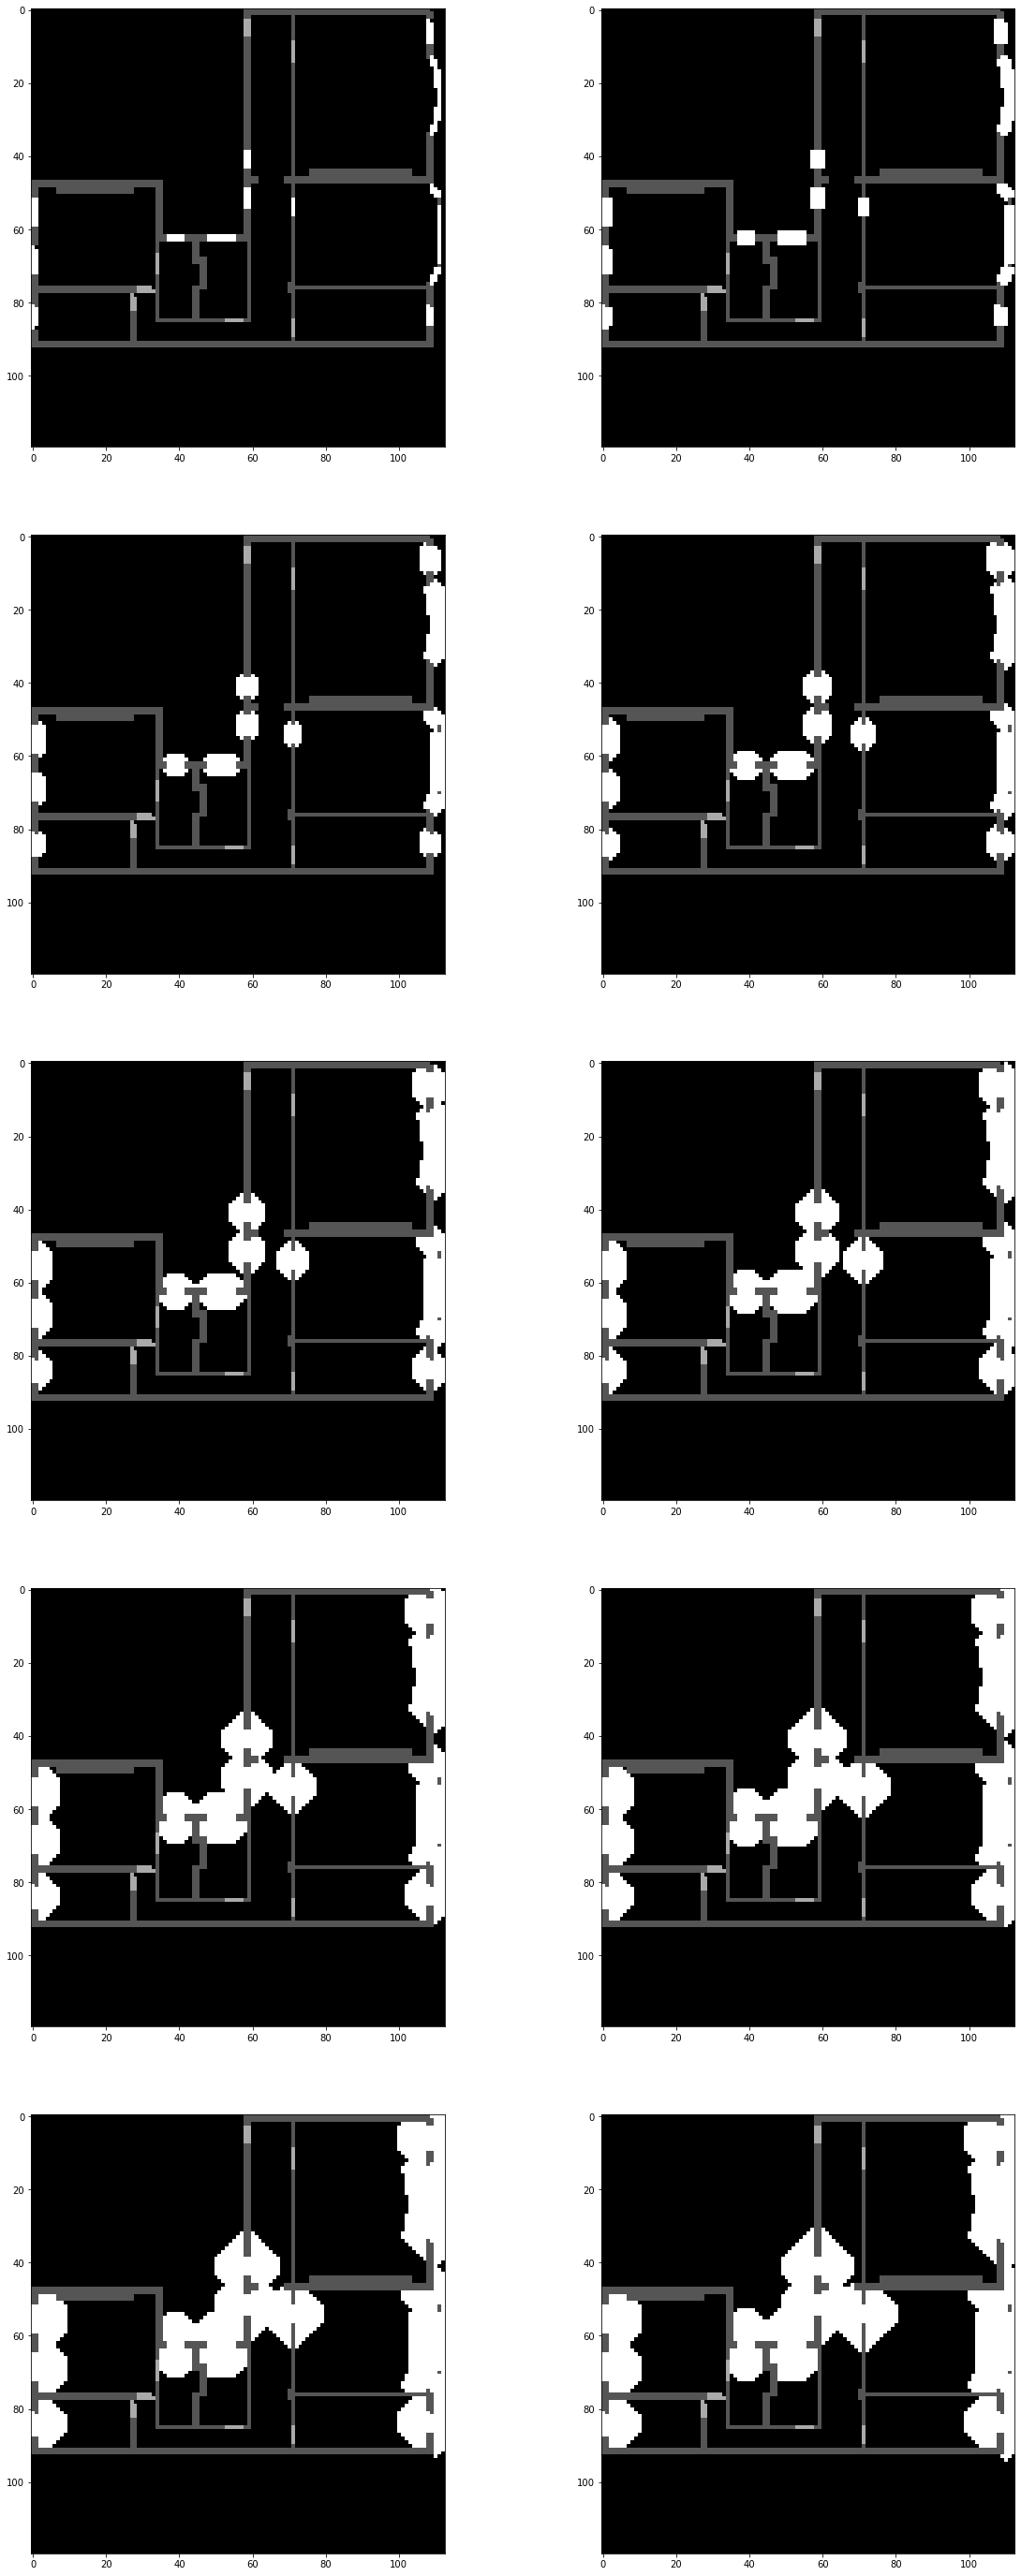

In [5]:
iter_num = 10

primitive_masks = np.ndarray(shape=(iter_num, *primitive_mask.shape), dtype=np.uint8)
primitive_masks[0] = primitive_mask.copy()

for idx in range(1, iter_num):
    previous_primitive_mask = primitive_masks[idx - 1].copy()
    neighbors = get_neighbor_pixels_of_label(previous_primitive_mask, Label.window)
    previous_primitive_mask[neighbors] = Label.window.value
    primitive_masks[idx] = previous_primitive_mask

plot_gray_images(*primitive_masks)

In [30]:
locations = PossibleLocations(get_neighbor_pixels_of_label(primitive_mask, Label.wall))

door_rating_mask = primitive_mask.copy()
for _ in range(10):
    neighbors = get_neighbor_pixels_of_label(door_rating_mask, Label.door)
    door_rating_mask[neighbors] = Label.door.value

locations.adjust_rating(where=(door_rating_mask == Label.door.value).nonzero(), rating_delta=-10)

window_rating_mask = primitive_mask.copy()
for _ in range(10):
    neighbors = get_neighbor_pixels_of_label(window_rating_mask, Label.window)
    window_rating_mask[neighbors] = Label.window.value

locations.adjust_rating(where=(window_rating_mask == Label.window.value).nonzero(), rating_delta=10)

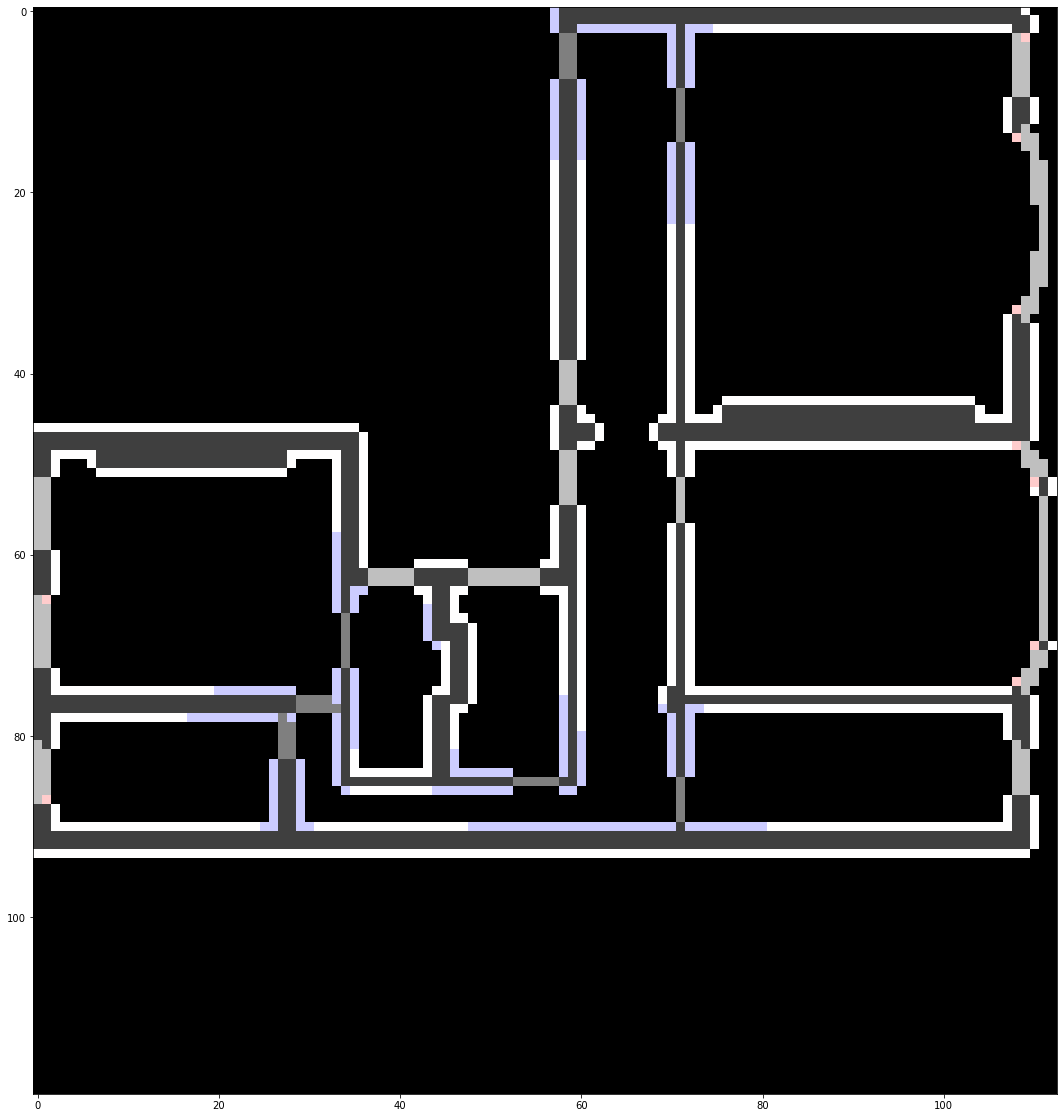

In [31]:
plot_location(primitive_mask, locations)